<a href="https://colab.research.google.com/github/kimdonggyu2008/deep_daiv_-/blob/main/fast_speech2_%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#fast speech2 파이프라인

kss 데이터와 textgrid 데이터 2종류를 다운받아야함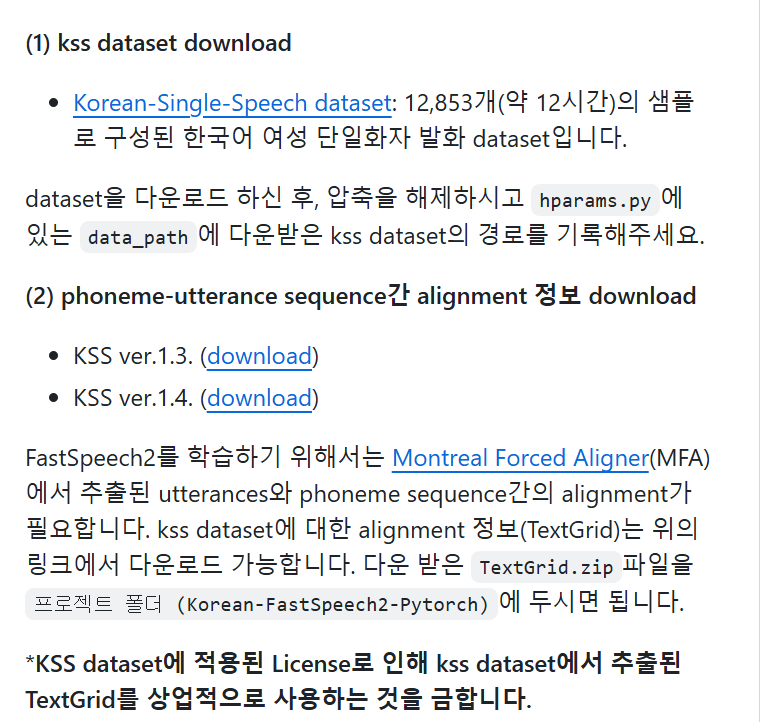

https://github.com/HGU-DLLAB/Korean-FastSpeech2-Pytorch

In [ ]:
# #데이터셋이 없는 경우에만 다운로드
# import os

# # Kaggle 데이터셋 다운로드
# !kaggle datasets download -d bryanpark/korean-single-speaker-speech-dataset -p /content/drive/MyDrive/fast_speech2

# # 압축 해제
# !unzip -q /content/drive/MyDrive/fast_speech2/korean-single-speaker-speech-dataset.zip -d /content/drive/MyDrive/fast_speech2/dataset
# print("Dataset saved to /content/drive/MyDrive/fast_speech2")

In [ ]:
from google.colab import drive, output
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r "/content/drive/MyDrive/fast_speech2/requirements.txt"
output.clear() #버전 에러가 나는 경우, 여기 확인

In [ ]:
!pip install g2pk
!pip install jamo
!pip install unidecode
!pip install pyworld
!pip install tgt
!pip install cleaners
!pip install utils
!pip install audio
output.clear()

In [ ]:
# Standard Libraries
import os
import shutil
import time
import re
import math
import json
import codecs
import argparse
from string import punctuation
from collections import OrderedDict
import copy
import ast
import inflect
import utils
import matplotlib.pyplot as plt
import matplotlib



# Numerical Computations
import numpy as np

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable


# Korean Language Libraries
from g2pk import G2p
from jamo import hangul_to_jamo, h2j, j2h, hcj_to_jamo, is_hcj
from jamo.jamo import _jamo_char_to_hcj
from unidecode import unidecode

# Audio and Signal Libraries
from scipy.io import wavfile
from scipy.io.wavfile import read, write
from scipy.signal import get_window
from librosa.util import pad_center, tiny
from librosa.filters import mel as librosa_mel_fn

import librosa.util as librosa_util
from librosa.filters import mel as librosa_mel_fn
import pyworld as pw
import tgt

# Scikit-learn
from sklearn.preprocessing import StandardScaler
output.clear()

# 하이퍼 파라미터, 필요 내용 분할필요

In [ ]:
import os

class HParams:
    # Dataset paths
    dataset = "kss"
    data_path = os.path.join("/content/drive/MyDrive/fast_speech2/dataset",dataset)#kss 데이터셋 위치
    meta_name = "transcript.v.1.4.txt"  # 음성 데이터 발화내용
    textgrid_name = "textgrid.zip" #?

    # GPU settings
    train_visible_devices = "0,1"
    synth_visible_devices = "0"

    # Text
    text_cleaners = ['korean_cleaners']

    # Audio and mel
    sampling_rate = 22050
    filter_length = 1024
    hop_length = 256
    win_length = 1024
    max_wav_value = 32768.0
    n_mel_channels = 80
    mel_fmin = 0
    mel_fmax = 8000

    f0_min = 71.0
    f0_max = 792.8
    energy_min = 0.0
    energy_max = 283.72

    # FastSpeech 2
    encoder_layer = 4
    encoder_head = 2
    encoder_hidden = 256
    decoder_layer = 4
    decoder_head = 2
    decoder_hidden = 256
    fft_conv1d_filter_size = 1024
    fft_conv1d_kernel_size = (9, 1)
    encoder_dropout = 0.2
    decoder_dropout = 0.2

    variance_predictor_filter_size = 256
    variance_predictor_kernel_size = 3
    variance_predictor_dropout = 0.5

    max_seq_len = 1000

    # Checkpoints and synthesis path, 원 계정에서 사용할 것
    # preprocessed_path = os.path.join("./preprocessed/", dataset)
    # checkpoint_path = os.path.join("/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/fast_speech_2/fast_speech2/checkpoint")
    # eval_path = os.path.join("/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/fast_speech_2/fast_speech2_korean_dataset/eval")
    # log_path = os.path.join("/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/fast_speech_2/logs")
    # test_path = "/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/fast_speech_2/result"

    preprocessed_path = os.path.join("/content/drive/MyDrive/fast_speech2/dataset/preprocessed/",dataset)
    checkpoint_path = os.path.join("/content/drive/MyDrive/fast_speech2/dataset/ckpt/",dataset)
    eval_path = os.path.join("/content/drive/MyDrive/fast_speech2/dataset/eval/", dataset)
    log_path = os.path.join("/content/drive/MyDrive/fast_speech2/dataset/log/", dataset)
    test_path = "/content/drive/MyDrive/fast_speech2/dataset/results"

    # Optimizer
    batch_size = 4
    epochs = 1000
    n_warm_up_step = 4000
    grad_clip_thresh = 1.0
    acc_steps = 1
    betas = (0.9, 0.98)
    eps = 1e-9
    weight_decay = 0.0


    # Vocoder, 나중에 원하는 모델로 변경 및 몇몇 함수 수정필요
    vocoder = 'vocgan'
    vocoder_pretrained_model_name = "" #사전 학습 모델 생기면 지정
    vocoder_pretrained_model_path = os.path.join("fast_speech2_pretrained")


    # Log-scaled duration
    log_offset = 1.

    # Save, log, and synthesis
    save_step = 10000
    eval_step = 1000
    eval_size = 256
    log_step = 1000
    clear_Time = 20


# Instantiate hparams for usage
hp = HParams()


#text파일

In [ ]:

PAD = '_'
EOS = '~'
PUNC = '!\'(),-.:;?'
SPACE = ' '
_SILENCES = ['sp', 'spn', 'sil']

JAMO_LEADS = "".join([chr(_) for _ in range(0x1100, 0x1113)])
JAMO_VOWELS = "".join([chr(_) for _ in range(0x1161, 0x1176)])
JAMO_TAILS = "".join([chr(_) for _ in range(0x11A8, 0x11C3)])

VALID_CHARS = JAMO_LEADS + JAMO_VOWELS + JAMO_TAILS + PUNC + SPACE
ALL_SYMBOLS = list(PAD + EOS + VALID_CHARS) + _SILENCES
s_to_i={c: i for i, c in enumerate(ALL_SYMBOLS)}
#print('s_to_i: ',s_to_i)
KOR_SYMBOLS=ALL_SYMBOLS

Kchar_to_id={c: i for i, c in enumerate(KOR_SYMBOLS)}
id_to_Kchar={i: c for i, c in enumerate(KOR_SYMBOLS)}

'''
Cleaners are transformations that run over the input text at both training and eval time.

Cleaners can be selected by passing a comma-delimited list of cleaner names as the "cleaners"
hyperparameter. Some cleaners are English-specific. You'll typically want to use:
  1. "english_cleaners" for English text
  2. "transliteration_cleaners" for non-English text that can be transliterated to ASCII using
     the Unidecode library (https://pypi.python.org/pypi/Unidecode)
  3. "basic_cleaners" if you do not want to transliterate (in this case, you should also update
     the symbols in symbols.py to match your data).
'''


'\nCleaners are transformations that run over the input text at both training and eval time.\n\nCleaners can be selected by passing a comma-delimited list of cleaner names as the "cleaners"\nhyperparameter. Some cleaners are English-specific. You\'ll typically want to use:\n  1. "english_cleaners" for English text\n  2. "transliteration_cleaners" for non-English text that can be transliterated to ASCII using\n     the Unidecode library (https://pypi.python.org/pypi/Unidecode)\n  3. "basic_cleaners" if you do not want to transliterate (in this case, you should also update\n     the symbols in symbols.py to match your data).\n'

In [ ]:
kor_symbols=KOR_SYMBOLS
symbols=kor_symbols

In [ ]:
# Mappings from symbol to numeric ID and vice versa:
_symbol_to_id = {s: i for i, s in enumerate(symbols)}
_id_to_symbol = {i: s for i, s in enumerate(symbols)}

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r'(.*?)\{(.+?)\}(.*)')


def text_to_sequence(text, cleaner_names):
    '''Converts a string of text to a sequence of IDs corresponding to the symbols in the text.

      The text can optionally have ARPAbet sequences enclosed in curly braces embedded
      in it. For example, "Turn left on {HH AW1 S S T AH0 N} Street."

      Args:
        text: string to convert to a sequence
        cleaner_names: names of the cleaner functions to run the text through

      Returns:
        List of integers corresponding to the symbols in the text
    '''

    sequence = []
    while len(text):
        m = _curly_re.match(text)
        if not m:
            print('not m!')
            sequence = _symbols_to_sequence(text)
            break
        sequence = _symbols_to_sequence(m.group(2))
        text = m.group(3)
    return sequence

def sequence_to_text(sequence):
    '''Converts a sequence of IDs back to a string'''
    result = ''
    for symbol_id in sequence:
        if symbol_id in _id_to_symbol:
            s = _id_to_symbol[symbol_id]
            # Enclose ARPAbet back in curly braces:
            if len(s) > 1 and s[0] == '@':
                s = '{%s}' % s[1:]
            result += s
    return result.replace('}{', ' ')


def _clean_text(text, cleaner_names):
    for name in cleaner_names:
        cleaner = getattr(cleaners, name)
        if not cleaner:
            raise Exception('Unknown cleaner: %s' % name)
        text = cleaner(text)
    return text


def _symbols_to_sequence(symbols):
    return [_symbol_to_id[s] for s in symbols.split() if _should_keep_symbol(s)]


def _arpabet_to_sequence(text):
    return _symbols_to_sequence(['@' + s for s in text.split()])


def _should_keep_symbol(s):
    #return s in _symbol_to_id and s is not '_' and s is not '~'
    return s in _symbol_to_id and s != '~' and s != '_'

if __name__ == "__main__":
    print()

In [ ]:
_inflect = inflect.engine()
_comma_number_re = re.compile(r'([0-9][0-9\,]+[0-9])')
_decimal_number_re = re.compile(r'([0-9]+\.[0-9]+)')
_pounds_re = re.compile(r'£([0-9\,]*[0-9]+)')
_dollars_re = re.compile(r'\$([0-9\.\,]*[0-9]+)')
_ordinal_re = re.compile(r'[0-9]+(st|nd|rd|th)')
_number_re = re.compile(r'[0-9]+')


def _remove_commas(m):
  return m.group(1).replace(',', '')


def _expand_decimal_point(m):
  return m.group(1).replace('.', ' point ')


def _expand_dollars(m):
  match = m.group(1)
  parts = match.split('.')
  if len(parts) > 2:
    return match + ' dollars'  # Unexpected format
  dollars = int(parts[0]) if parts[0] else 0
  cents = int(parts[1]) if len(parts) > 1 and parts[1] else 0
  if dollars and cents:
    dollar_unit = 'dollar' if dollars == 1 else 'dollars'
    cent_unit = 'cent' if cents == 1 else 'cents'
    return '%s %s, %s %s' % (dollars, dollar_unit, cents, cent_unit)
  elif dollars:
    dollar_unit = 'dollar' if dollars == 1 else 'dollars'
    return '%s %s' % (dollars, dollar_unit)
  elif cents:
    cent_unit = 'cent' if cents == 1 else 'cents'
    return '%s %s' % (cents, cent_unit)
  else:
    return 'zero dollars'


def _expand_ordinal(m):
  return _inflect.number_to_words(m.group(0))


def _expand_number(m):
  num = int(m.group(0))
  if num > 1000 and num < 3000:
    if num == 2000:
      return 'two thousand'
    elif num > 2000 and num < 2010:
      return 'two thousand ' + _inflect.number_to_words(num % 100)
    elif num % 100 == 0:
      return _inflect.number_to_words(num // 100) + ' hundred'
    else:
      return _inflect.number_to_words(num, andword='', zero='oh', group=2).replace(', ', ' ')
  else:
    return _inflect.number_to_words(num, andword='')


def normalize_numbers(text):
  text = re.sub(_comma_number_re, _remove_commas, text)
  text = re.sub(_pounds_re, r'\1 pounds', text)
  text = re.sub(_dollars_re, _expand_dollars, text)
  text = re.sub(_decimal_number_re, _expand_decimal_point, text)
  text = re.sub(_ordinal_re, _expand_ordinal, text)
  text = re.sub(_number_re, _expand_number, text)
  return text


In [ ]:


_whitespace_re = re.compile(r'\s+')

# List of (regular expression, replacement) pairs for abbreviations:
_abbreviations = [(re.compile('\\b%s\\.' % x[0], re.IGNORECASE), x[1]) for x in [
    ('mrs', 'misess'),
    ('mr', 'mister'),
    ('dr', 'doctor'),
    ('st', 'saint'),
    ('co', 'company'),
    ('jr', 'junior'),
    ('maj', 'major'),
    ('gen', 'general'),
    ('drs', 'doctors'),
    ('rev', 'reverend'),
    ('lt', 'lieutenant'),
    ('hon', 'honorable'),
    ('sgt', 'sergeant'),
    ('capt', 'captain'),
    ('esq', 'esquire'),
    ('ltd', 'limited'),
    ('col', 'colonel'),
    ('ft', 'fort'),
]]


def expand_abbreviations(text):
    for regex, replacement in _abbreviations:
        text = re.sub(regex, replacement, text)
    return text


def expand_numbers(text):
    return normalize_numbers(text)


def lowercase(text):
    return text.lower()


def collapse_whitespace(text):
    return re.sub(_whitespace_re, ' ', text)


def convert_to_ascii(text):
    return unidecode(text)


def basic_cleaners(text):
    '''Basic pipeline that lowercases and collapses whitespace without transliteration.'''
    text = lowercase(text)
    text = collapse_whitespace(text)
    return text


def transliteration_cleaners(text):
    '''Pipeline for non-English text that transliterates to ASCII.'''
    text = convert_to_ascii(text)
    text = lowercase(text)
    text = collapse_whitespace(text)
    return text


def english_cleaners(text):
    '''Pipeline for English text, including number and abbreviation expansion.'''
    text = convert_to_ascii(text)
    text = lowercase(text)
    text = expand_numbers(text)
    text = expand_abbreviations(text)
    text = collapse_whitespace(text)
    return text

def korean_cleaners(text):
    text=ko_tokenize(text, as_id=False)
    return text

""" from https://github.com/keithito/tacotron """

'''
Defines the set of symbols used in text input to the model.

The default is a set of ASCII characters that works well for English or text that has been run through Unidecode. For other data, you can modify _characters. See TRAINING_DATA.md for details.
'''
kor_symbols=KOR_SYMBOLS
symbols=kor_symbols

#트랜스포머 파일(트랜스포머 구현인듯?)

In [ ]:
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [ ]:
class FFTBlock(torch.nn.Module):
    """FFT Block"""

    def __init__(self,
                 d_model,
                 d_inner,
                 n_head,
                 d_k,
                 d_v,
                 dropout=0.1):
        super(FFTBlock, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(
            d_model, d_inner, dropout=dropout)
    def forward(self, enc_input, mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = enc_output.masked_fill(mask.unsqueeze(-1), 0)

        enc_output = self.pos_ffn(enc_output)
        enc_output = enc_output.masked_fill(mask.unsqueeze(-1), 0)

        return enc_output, enc_slf_attn


class ConvNorm(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=1,
                 stride=1,
                 padding=None,
                 dilation=1,
                 bias=True,
                 w_init_gain='linear'):
        super(ConvNorm, self).__init__()

        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels,
                                    out_channels,
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    padding=padding,
                                    dilation=dilation,
                                    bias=bias)

    def forward(self, signal):
        conv_signal = self.conv(signal)

        return conv_signal


class PostNet(nn.Module):
    """
    PostNet: Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self,
                 n_mel_channels=80,
                 postnet_embedding_dim=512,
                 postnet_kernel_size=5,
                 postnet_n_convolutions=5):

        super(PostNet, self).__init__()
        self.convolutions = nn.ModuleList()

        self.convolutions.append(
            nn.Sequential(
                ConvNorm(n_mel_channels,
                         postnet_embedding_dim,
                         kernel_size=postnet_kernel_size,
                         stride=1,
                         padding=int((postnet_kernel_size - 1) / 2),
                         dilation=1,
                         w_init_gain='tanh'),

                nn.BatchNorm1d(postnet_embedding_dim))
        )

        for i in range(1, postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm(postnet_embedding_dim,
                             postnet_embedding_dim,
                             kernel_size=postnet_kernel_size,
                             stride=1,
                             padding=int((postnet_kernel_size - 1) / 2),
                             dilation=1,
                             w_init_gain='tanh'),

                    nn.BatchNorm1d(postnet_embedding_dim))
            )

        self.convolutions.append(
            nn.Sequential(
                ConvNorm(postnet_embedding_dim,
                         n_mel_channels,
                         kernel_size=postnet_kernel_size,
                         stride=1,
                         padding=int((postnet_kernel_size - 1) / 2),
                         dilation=1,
                         w_init_gain='linear'),

                nn.BatchNorm1d(n_mel_channels))
        )

    def forward(self, x):
        x = x.contiguous().transpose(1, 2)

        for i in range(len(self.convolutions) - 1):
            x = F.dropout(torch.tanh(
                self.convolutions[i](x)), 0.5, self.training)
        x = F.dropout(self.convolutions[-1](x), 0.5, self.training)

        x = x.contiguous().transpose(1, 2)
        return x

In [ ]:
def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    ''' Sinusoid position encoding table '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i)
                               for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return torch.FloatTensor(sinusoid_table)


class Encoder(nn.Module):
    ''' Encoder '''

    def __init__(self,
                 n_src_vocab=len(symbols)+1,
                 len_max_seq=hp.max_seq_len,
                 d_word_vec=hp.encoder_hidden,
                 n_layers=hp.encoder_layer,
                 n_head=hp.encoder_head,
                 d_k=hp.encoder_hidden // hp.encoder_head,
                 d_v=hp.encoder_hidden // hp.encoder_head,
                 d_model=hp.encoder_hidden,
                 d_inner=hp.fft_conv1d_filter_size,
                 dropout=hp.encoder_dropout):

        super(Encoder, self).__init__()

        n_position = len_max_seq + 1

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=Constants.PAD)
        self.position_enc = nn.Parameter(
            get_sinusoid_encoding_table(n_position, d_word_vec).unsqueeze(0), requires_grad=False)

        self.layer_stack = nn.ModuleList([FFTBlock(
            d_model, d_inner, n_head, d_k, d_v, dropout=dropout) for _ in range(n_layers)])

    def forward(self, src_seq, mask, return_attns=False):

        enc_slf_attn_list = []
        batch_size, max_len = src_seq.shape[0], src_seq.shape[1]

        # -- Prepare masks
        slf_attn_mask = mask.unsqueeze(1).expand(-1, max_len, -1)

        # -- Forward
        if not self.training and src_seq.shape[1] > hp.max_seq_len:
            enc_output = self.src_word_emb(src_seq) + get_sinusoid_encoding_table(src_seq.shape[1], hp.encoder_hidden)[:src_seq.shape[1], :].unsqueeze(0).expand(batch_size, -1, -1).to(src_seq.device)
        else:
            enc_output = self.src_word_emb(src_seq) + self.position_enc[:, :max_len, :].expand(batch_size, -1, -1)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output,
                mask=mask,
                slf_attn_mask=slf_attn_mask)
            if return_attns:
                enc_slf_attn_list += [enc_slf_attn]

        return enc_output


class Decoder(nn.Module):
    """ Decoder """

    def __init__(self,
                 len_max_seq=hp.max_seq_len,
                 d_word_vec=hp.encoder_hidden,
                 n_layers=hp.decoder_layer,
                 n_head=hp.decoder_head,
                 d_k=hp.decoder_hidden // hp.decoder_head,
                 d_v=hp.decoder_hidden // hp.decoder_head,
                 d_model=hp.decoder_hidden,
                 d_inner=hp.fft_conv1d_filter_size,
                 dropout=hp.decoder_dropout):

        super(Decoder, self).__init__()

        n_position = len_max_seq + 1

        self.position_enc = nn.Parameter(
            get_sinusoid_encoding_table(n_position, d_word_vec).unsqueeze(0), requires_grad=False)

        self.layer_stack = nn.ModuleList([FFTBlock(
            d_model, d_inner, n_head, d_k, d_v, dropout=dropout) for _ in range(n_layers)])

    def forward(self, enc_seq, mask, return_attns=False):

        dec_slf_attn_list = []
        batch_size, max_len = enc_seq.shape[0], enc_seq.shape[1]

        # -- Prepare masks
        slf_attn_mask = mask.unsqueeze(1).expand(-1, max_len, -1)

        # -- Forward
        if not self.training and enc_seq.shape[1] > hp.max_seq_len:
            dec_output = enc_seq + get_sinusoid_encoding_table(enc_seq.shape[1], hp.decoder_hidden)[:enc_seq.shape[1], :].unsqueeze(0).expand(batch_size, -1, -1).to(enc_seq.device)
        else:
            dec_output = enc_seq + self.position_enc[:, :max_len, :].expand(batch_size, -1, -1)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn = dec_layer(
                dec_output,
                mask=mask,
                slf_attn_mask=slf_attn_mask)
            if return_attns:
                dec_slf_attn_list += [dec_slf_attn]

        return dec_output

In [ ]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)

        attn = self.softmax(attn)
        output = torch.bmm(attn, v)

        return output, attn

In [ ]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)

        self.attention = ScaledDotProductAttention(
            temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        q = q.permute(2, 0, 1, 3).contiguous().view(-1,
                                                    len_q, d_k)  # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1,
                                                    len_k, d_k)  # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1,
                                                    len_v, d_v)  # (n*b) x lv x dv

        mask = mask.repeat(n_head, 1, 1)  # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(
            sz_b, len_q, -1)  # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output, attn


class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()

        # Use Conv1D
        # position-wise
        self.w_1 = nn.Conv1d(
            d_in, d_hid, kernel_size=hp.fft_conv1d_kernel_size[0], padding=(hp.fft_conv1d_kernel_size[0]-1)//2)
        # position-wise
        self.w_2 = nn.Conv1d(
            d_hid, d_in, kernel_size=hp.fft_conv1d_kernel_size[1], padding=(hp.fft_conv1d_kernel_size[1]-1)//2)

        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)

        return output

#utils.py


In [ ]:
matplotlib.use("Agg")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_alignment(tier): #파일 분석
    sil_phones = ['sil', 'sp', 'spn']

    phones = []
    durations = []
    start_time = 0
    end_time = 0
    end_idx = 0
    for t in tier._objects:
        s, e, p = t.start_time, t.end_time, t.text

        # Trimming leading silences
        if phones == []:
            if p in sil_phones:
                continue
            else:
                start_time = s
        if p not in sil_phones:
            phones.append(p)
            end_time = e
            end_idx = len(phones)
        else:
            phones.append(p)
        durations.append(int(e*hp.sampling_rate/hp.hop_length)-int(s*hp.sampling_rate/hp.hop_length))

    # Trimming tailing silences
    phones = phones[:end_idx]
    durations = durations[:end_idx]

    return phones, np.array(durations), start_time, end_time

def process_meta(meta_path): #메타데이터(대본) 추출 및 분할
    with open(meta_path, "r", encoding="utf-8") as f:
        text = []
        name = []
        for line in f.readlines():
            n, t = line.strip('\n').split('|')
            name.append(n)
            text.append(t)
        return name, text

def get_param_num(model):
    num_param = sum(param.numel() for param in model.parameters())
    return num_param

def plot_data(data, titles=None, filename=None):
    fig, axes = plt.subplots(len(data), 1, squeeze=False)
    if titles is None:
        titles = [None for i in range(len(data))]

    def add_axis(fig, old_ax, offset=0):
        ax = fig.add_axes(old_ax.get_position(), anchor='W')
        ax.set_facecolor("None")
        return ax

    for i in range(len(data)):
        spectrogram, pitch, energy = data[i]
        axes[i][0].imshow(spectrogram, origin='lower')
        axes[i][0].set_aspect(2.5, adjustable='box')
        axes[i][0].set_ylim(0, hp.n_mel_channels)
        axes[i][0].set_title(titles[i], fontsize='medium')
        axes[i][0].tick_params(labelsize='x-small', left=False, labelleft=False)
        axes[i][0].set_anchor('W')

        ax1 = add_axis(fig, axes[i][0])
        ax1.plot(pitch, color='tomato')
        ax1.set_xlim(0, spectrogram.shape[1])
        ax1.set_ylim(0, hp.f0_max)
        ax1.set_ylabel('F0', color='tomato')
        ax1.tick_params(labelsize='x-small', colors='tomato', bottom=False, labelbottom=False)

        ax2 = add_axis(fig, axes[i][0], 1.2)
        ax2.plot(energy, color='darkviolet')
        ax2.set_xlim(0, spectrogram.shape[1])
        ax2.set_ylim(hp.energy_min, hp.energy_max)
        ax2.set_ylabel('Energy', color='darkviolet')
        ax2.yaxis.set_label_position('right')
        ax2.tick_params(labelsize='x-small', colors='darkviolet', bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)

    plt.savefig(filename, dpi=200)
    plt.close()

def get_mask_from_lengths(lengths, max_len=None): #마스크 길이 가져옴
    batch_size = lengths.shape[0]
    if max_len is None:
        max_len = torch.max(lengths).item()

    ids = torch.arange(0, max_len).unsqueeze(0).expand(batch_size, -1).to(device)
    mask = (ids >= lengths.unsqueeze(1).expand(-1, max_len))

    return mask

"""
원본은 vocgan 사용함, 이 부분을 다른 모델로 바꿔서 들고오면 될듯?
"""
def get_vocgan(ckpt_path, n_mel_channels=hp.n_mel_channels, generator_ratio = [4, 4, 2, 2, 2, 2], n_residual_layers=4, mult=256, out_channels=1): #vocgan 사용하는 경우

    checkpoint = torch.load(ckpt_path)
    model = Generator(n_mel_channels, n_residual_layers,
                        ratios=generator_ratio, mult=mult,
                        out_band=out_channels)

    model.load_state_dict(checkpoint['model_g'])
    model.to(device).eval()

    return model



def vocgan_infer(mel, vocoder, path):
    model = vocoder

    with torch.no_grad():
        if len(mel.shape) == 2:
            mel = mel.unsqueeze(0)

        audio = model.infer(mel).squeeze()
        audio = hp.max_wav_value * audio[:-(hp.hop_length*10)]
        audio = audio.clamp(min=-hp.max_wav_value, max=hp.max_wav_value-1)
        audio = audio.short().cpu().detach().numpy()

        wavfile.write(path, hp.sampling_rate, audio)
"""
"""

# 1차원 패딩 함수
def pad_1D(inputs, PAD=0):

    def pad_data(x, length, PAD):
        x_padded = np.pad(x, (0, length - x.shape[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded

    max_len = max((len(x) for x in inputs))
    padded = np.stack([pad_data(x, max_len, PAD) for x in inputs])

    return padded

#2차원 패딩
def pad_2D(inputs, maxlen=None):

    def pad(x, max_len):
        PAD = 0
        if np.shape(x)[0] > max_len:
            raise ValueError("not max_len")

        s = np.shape(x)[1]
        x_padded = np.pad(x, (0, max_len - np.shape(x)[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded[:, :s]

    if maxlen:
        output = np.stack([pad(x, maxlen) for x in inputs])
    else:
        max_len = max(np.shape(x)[0] for x in inputs)
        output = np.stack([pad(x, max_len) for x in inputs])

    return output

#입력값에 따라서 패딩을 다르게 걸기?
def pad(input_ele, mel_max_length=None):
    if mel_max_length:
        max_len = mel_max_length
    else:
        max_len = max([input_ele[i].size(0)for i in range(len(input_ele))])

    out_list = list()
    for i, batch in enumerate(input_ele):
        if len(batch.shape) == 1:
            one_batch_padded = F.pad(
                batch, (0, max_len-batch.size(0)), "constant", 0.0)
        elif len(batch.shape) == 2:
            one_batch_padded = F.pad(
                batch, (0, 0, 0, max_len-batch.size(0)), "constant", 0.0)
        out_list.append(one_batch_padded)
    out_padded = torch.stack(out_list)
    return out_padded

# from dathudeptrai's FastSpeech2 implementation
def standard_norm(x, mean, std, is_mel=False):

    if not is_mel:
        x = remove_outlier(x)

    zero_idxs = np.where(x == 0.0)[0]
    x = (x - mean) / std
    x[zero_idxs] = 0.0
    return x

def standard_norm_torch(x, mean, std):

    zero_idxs = torch.where(x == 0.0)[0]
    x = (x - mean) / std
    x[zero_idxs] = 0.0
    return x



def de_norm(x, mean, std):
    zero_idxs = torch.where(x == 0.0)[0]
    x = mean + std * x
    x[zero_idxs] = 0.0
    return x


def _is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)

    return np.logical_or(x <= lower, x >= upper)


def remove_outlier(x):
    """Remove outlier from x."""
    p25 = np.percentile(x, 25)
    p75 = np.percentile(x, 75)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if _is_outlier(value, p25, p75):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0

    # replace by mean f0.
    x[indices_of_outliers] = np.max(x)
    return x

def average_by_duration(x, durs):
    mel_len = durs.sum()
    durs_cum = np.cumsum(np.pad(durs, (1, 0)))

    # calculate charactor f0/energy
    x_char = np.zeros((durs.shape[0],), dtype=np.float32)
    for idx, start, end in zip(range(mel_len), durs_cum[:-1], durs_cum[1:]):
        values = x[start:end][np.where(x[start:end] != 0.0)[0]]
        x_char[idx] = np.mean(values) if len(values) > 0 else 0.0  # np.mean([]) = nan.

    return x_char.astype(np.float32)

#audio 파일

In [ ]:

class STFT(torch.nn.Module):

    def __init__(self, filter_length, hop_length, win_length,
                 window='hann'):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(
            np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = librosa_util.pad_center(fft_window, size=filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window
            inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data): #데이터 변환
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data.cuda(),
            Variable(self.forward_basis, requires_grad=False).cuda(),
            stride=self.hop_length,
            padding=0).cpu()

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase

    def inverse(self, magnitude, phase): #데이터 역변환
        recombine_magnitude_phase = torch.cat(
            [magnitude*torch.cos(phase), magnitude*torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(
            recombine_magnitude_phase,
            Variable(self.inverse_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        if self.window is not None:
            window_sum = window_sumsquare(
                self.window, magnitude.size(-1), hop_length=self.hop_length,
                win_length=self.win_length, n_fft=self.filter_length,
                dtype=np.float32)
            # remove modulation effects
            approx_nonzero_indices = torch.from_numpy(
                np.where(window_sum > tiny(window_sum))[0])
            window_sum = torch.autograd.Variable(
                torch.from_numpy(window_sum), requires_grad=False)
            window_sum = window_sum.cuda() if magnitude.is_cuda else window_sum
            inverse_transform[:, :,
                              approx_nonzero_indices] /= window_sum[approx_nonzero_indices]

            # scale by hop ratio
            inverse_transform *= float(self.filter_length) / self.hop_length

        inverse_transform = inverse_transform[:, :, int(self.filter_length/2):]
        inverse_transform = inverse_transform[:,
                                              :, :-int(self.filter_length/2):]

        return inverse_transform

    def forward(self, input_data): #재구성인듯?
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction


In [ ]:
class TacotronSTFT(torch.nn.Module): #stft
    def __init__(self, filter_length, hop_length, win_length,
                 n_mel_channels, sampling_rate, mel_fmin=0.0,
                 mel_fmax=8000.0):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length)
        mel_basis = librosa_mel_fn(
            sr=sampling_rate, n_fft=filter_length, n_mels=n_mel_channels, fmin=mel_fmin, fmax=mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """
        assert(torch.min(y.data) >= -1)
        assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        energy = torch.norm(magnitudes, dim=1)

        return mel_output, energy



In [ ]:
def window_sumsquare(window, n_frames, hop_length=hp.hop_length, win_length=hp.win_length,
                     n_fft=hp.filter_length, dtype=np.float32, norm=None):
    """
    # from librosa 0.6
    Compute the sum-square envelope of a window function at a given hop length.

    This is used to estimate modulation effects induced by windowing
    observations in short-time fourier transforms.

    Parameters
    ----------
    window : string, tuple, number, callable, or list-like
        Window specification, as in `get_window`

    n_frames : int > 0
        The number of analysis frames

    hop_length : int > 0
        The number of samples to advance between frames

    win_length : [optional]
        The length of the window function.  By default, this matches `n_fft`.

    n_fft : int > 0
        The length of each analysis frame.

    dtype : np.dtype
        The data type of the output

    Returns
    -------
    wss : np.ndarray, shape=`(n_fft + hop_length * (n_frames - 1))`
        The sum-squared envelope of the window function
    """
    if win_length is None:
        win_length = n_fft

    n = n_fft + hop_length * (n_frames - 1)
    x = np.zeros(n, dtype=dtype)

    # Compute the squared window at the desired length
    win_sq = get_window(window, win_length, fftbins=True)
    win_sq = librosa_util.normalize(win_sq, norm=norm)**2
    win_sq = librosa_util.pad_center(win_sq, n_fft)

    # Fill the envelope
    for i in range(n_frames):
        sample = i * hop_length
        x[sample:min(n, sample + n_fft)
          ] += win_sq[:max(0, min(n_fft, n - sample))]
    return x


def griffin_lim(magnitudes, stft_fn, n_iters=30):
    """
    PARAMS
    ------
    magnitudes: spectrogram magnitudes
    stft_fn: STFT class with transform (STFT) and inverse (ISTFT) methods
    """

    angles = np.angle(np.exp(2j * np.pi * np.random.rand(*magnitudes.size())))
    angles = angles.astype(np.float32)
    angles = torch.autograd.Variable(torch.from_numpy(angles))
    signal = stft_fn.inverse(magnitudes, angles).squeeze(1)

    for i in range(n_iters):
        _, angles = stft_fn.transform(signal)
        signal = stft_fn.inverse(magnitudes, angles).squeeze(1)
    return signal


def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return torch.exp(x) / C




In [ ]:
_stft = TacotronSTFT( #주어진 데이터에 대해 stft 실행
    hp.filter_length, hp.hop_length, hp.win_length,
    hp.n_mel_channels, hp.sampling_rate, hp.mel_fmin,
    hp.mel_fmax)

In [ ]:

def load_wav_to_torch(full_path):
    sampling_rate, data = read(full_path)
    return torch.FloatTensor(data.astype(np.float32)), sampling_rate


def get_mel(filename):
    audio, sampling_rate = load_wav_to_torch(filename)
    if sampling_rate != _stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, _stft.sampling_rate))
    audio_norm = audio / hp.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec, energy = _stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0)
    energy = torch.squeeze(energy, 0)
    # melspec = torch.from_numpy(_normalize(melspec.numpy()))

    return melspec, energy


def get_mel_from_wav(audio):
    sampling_rate = hp.sampling_rate
    if sampling_rate != _stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, _stft.sampling_rate))
    audio_norm = audio / hp.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec, energy = _stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0)
    energy = torch.squeeze(energy, 0)

    return melspec, energy


def inv_mel_spec(mel, out_filename, griffin_iters=60):
    mel = torch.stack([mel])
    # mel = torch.stack([torch.from_numpy(_denormalize(mel.numpy()))])
    mel_decompress = _stft.spectral_de_normalize(mel)
    mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
    spec_from_mel_scaling = 1000
    spec_from_mel = torch.mm(mel_decompress[0], _stft.mel_basis)
    spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
    spec_from_mel = spec_from_mel * spec_from_mel_scaling

    audio = griffin_lim(torch.autograd.Variable(
        spec_from_mel[:, :, :-1]), _stft.stft_fn, griffin_iters)

    audio = audio.squeeze()
    audio = audio.cpu().numpy()
    audio_path = out_filename
    write(audio_path, hp.sampling_rate, audio)

#data 파일

In [ ]:
def prepare_align(in_dir, meta): #데이터 처리용 라이브러리
    with open(os.path.join(in_dir, meta), encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('|')
            basename, text = parts[0], parts[1]

            basename=basename.replace('.wav','.txt')

            with open(os.path.join(in_dir,'wavs',basename),'w') as f1:
                f1.write(text)

def build_from_path(in_dir, out_dir, meta): #데이터 정규화 및 f0, 에너지, 멜 생성
    train, val = list(), list()

    scalers = [StandardScaler(copy=False) for _ in range(3)]	# scalers for mel, f0, energy

    n_frames = 0

    with open(os.path.join(in_dir, meta)) as f:
        for index, line in enumerate(f):

            parts = line.strip().split('|')
            basename, text = parts[0], parts[1]

            ret = process_utterance(in_dir, out_dir, basename, scalers)

            if ret is None:
                continue
            else:
                info, n = ret

            if basename[0] == '1': #1번 파일만 검증, 나머지는 학습으로 사용, 여기서 타겟 지정해서 하면 될듯?
                val.append(info)
            else:
                train.append(info)

            if index % 100 == 0:
                print("Done %d" % index)

            n_frames += n

    param_list = [np.array([scaler.mean_, scaler.scale_]) for scaler in scalers]
    param_name_list = ['mel_stat.npy', 'f0_stat.npy', 'energy_stat.npy']
    [np.save(os.path.join(out_dir, param_name), param_list[idx]) for idx, param_name in enumerate(param_name_list)]

    return [r for r in train if r is not None], [r for r in val if r is not None]


def process_utterance(in_dir, out_dir, basename, scalers): #wav별 실행
    wav_bak_basename=basename.replace('.wav','')
    basename = wav_bak_basename[2:]
    wav_bak_path = os.path.join(in_dir, "wavs_bak", "{}.wav".format(wav_bak_basename))
    wav_path = os.path.join(in_dir, 'wavs', '{}.wav'.format(basename))
    textgrid_name=hp.textgrid_name.replace(".zip","")

    # Convert kss data into PCM encoded wavs
    if not os.path.isfile(wav_path):
        os.system("ffmpeg -i {} -ac 1 -ar 22050 {}".format(wav_bak_path, wav_path))
    tg_path = os.path.join(out_dir, textgrid_name, '{}.TextGrid'.format(basename))

    # Get alignments
    textgrid = tgt.io.read_textgrid(tg_path)
    phone, duration, start, end = get_alignment(textgrid.get_tier_by_name('phones'))
    print("phone : {}\nduration: {}\nstart : {}\n,end : {}\n".format(phone,duration,start,end))

    text = '{'+ '}{'.join(phone) + '}' # '{A}{B}{$}{C}', $ represents silent phones
    text = text.replace('{$}', ' ')    # '{A}{B} {C}'
    text = text.replace('}{', ' ')     # '{A B} {C}'


    if start >= end:
        return None

    # Read and trim wav files
    _, wav = read(wav_path)
    wav = wav[int(hp.sampling_rate*start):int(hp.sampling_rate*end)].astype(np.float32) #샘플레이트

    # Compute fundamental frequency
    f0, _ = pw.dio(wav.astype(np.float64), hp.sampling_rate, frame_period=hp.hop_length/hp.sampling_rate*1000) #f0 추측
    f0 = f0[:sum(duration)]

    # Compute mel-scale spectrogram and energy
    mel_spectrogram, energy = Audio.tools.get_mel_from_wav(torch.FloatTensor(wav)) #wav에서 멜 추출, 에너지 추출
    mel_spectrogram = mel_spectrogram.numpy().astype(np.float32)[:, :sum(duration)]
    energy = energy.numpy().astype(np.float32)[:sum(duration)]

    f0, energy = remove_outlier(f0), remove_outlier(energy)
    f0, energy = average_by_duration(f0, duration), average_by_duration(energy, duration)

    if mel_spectrogram.shape[1] >= hp.max_seq_len:
        return None

    # Save alignment
    ali_filename = '{}-ali-{}.npy'.format(hp.dataset, basename)
    np.save(os.path.join(out_dir, 'alignment', ali_filename), duration, allow_pickle=False)

    # Save fundamental prequency
    f0_filename = '{}-f0-{}.npy'.format(hp.dataset, basename)
    np.save(os.path.join(out_dir, 'f0', f0_filename), f0, allow_pickle=False)

    # Save energy
    energy_filename = '{}-energy-{}.npy'.format(hp.dataset, basename)
    np.save(os.path.join(out_dir, 'energy', energy_filename), energy, allow_pickle=False)

    # Save spectrogram
    mel_filename = '{}-mel-{}.npy'.format(hp.dataset, basename)
    np.save(os.path.join(out_dir, 'mel', mel_filename), mel_spectrogram.T, allow_pickle=False)

    mel_scaler, f0_scaler, energy_scaler = scalers

    mel_scaler.partial_fit(mel_spectrogram.T)
    f0_scaler.partial_fit(f0[f0!=0].reshape(-1, 1))
    energy_scaler.partial_fit(energy[energy != 0].reshape(-1, 1))

    return '|'.join([basename, text]), mel_spectrogram.shape[1]

#prepare_align.py

In [ ]:
def main(): #데이터 전처리
    in_dir = hp.data_path
    if hp.dataset == "korean":
        prepare_align(in_dir, hp.meta_name)
if __name__ == "__main__":
    main()

#preprocess.py

In [ ]:
#데이터 전처리, 메타데이터 작성
def write_metadata(train, val, out_dir): #학습 데이터셋, 검증 데이터셋용 메타데이터 생성
    with open(os.path.join(out_dir, 'train.txt'), 'w', encoding='utf-8') as f:
        for m in train:
            f.write(m + '\n')
    with open(os.path.join(out_dir, 'val.txt'), 'w', encoding='utf-8') as f:
        for m in val:
            f.write(m + '\n')


In [ ]:

def main():
    in_dir = hp.data_path
    out_dir = hp.preprocessed_path
    meta = hp.meta_name
    textgrid_name = hp.textgrid_name

    mel_out_dir = os.path.join(out_dir, "mel")
    if not os.path.exists(mel_out_dir):
        os.makedirs(mel_out_dir, exist_ok=True)

    ali_out_dir = os.path.join(out_dir, "alignment")
    if not os.path.exists(ali_out_dir):
        os.makedirs(ali_out_dir, exist_ok=True)

    f0_out_dir = os.path.join(out_dir, "f0")
    if not os.path.exists(f0_out_dir):
        os.makedirs(f0_out_dir, exist_ok=True)

    energy_out_dir = os.path.join(out_dir, "energy")
    if not os.path.exists(energy_out_dir):
        os.makedirs(energy_out_dir, exist_ok=True)

    if os.path.isfile(textgrid_name):
        os.system('mv ./{} {}'.format(textgrid_name, out_dir))

    if not os.path.exists(os.path.join(out_dir, textgrid_name.replace(".zip", ""))):
        os.system('unzip {} -d {}'.format(os.path.join(out_dir, textgrid_name), out_dir))


    if "kss" in hp.dataset:
        # kss version 1.3
        if "v.1.3" in meta:
            if not os.path.exists(os.path.join(in_dir, "wavs_bak")):
                os.system("mv {} {}".format(os.path.join(in_dir, "wavs"), os.path.join(in_dir, "wavs_bak")))
                os.makedirs(os.path.join(in_dir, "wavs"))

        # kss version 1.4
        if "v.1.4" in meta:
            if not os.path.exists(os.path.join(in_dir, "wavs_bak")):
                os.makedirs(os.path.join(in_dir, "wavs"))
                os.system("mv {} {}".format(os.path.join(in_dir, "../", meta), os.path.join(in_dir)))
                for i in range(1, 5) : os.system("mv {} {}".format(os.path.join(in_dir, str(i)), os.path.join(in_dir, "wavs")))
                os.system("mv {} {}".format(os.path.join(in_dir, "wavs"), os.path.join(in_dir, "wavs_bak")))
                os.makedirs(os.path.join(in_dir, "wavs"))

        train, val = build_from_path(in_dir, out_dir, meta)

    write_metadata(train, val, out_dir)

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/fast_speech2/dataset/preprocessed/kss/textgrid/1_0000.TextGrid'

#loss.py


In [ ]:

class FastSpeech2Loss(nn.Module): #로스값 계산
    """ FastSpeech2 Loss """

    def __init__(self):
        super(FastSpeech2Loss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()

    def forward(self, log_d_predicted, log_d_target, p_predicted, p_target, e_predicted, e_target, mel, mel_postnet, mel_target, src_mask, mel_mask):
        log_d_target.requires_grad = False
        p_target.requires_grad = False
        e_target.requires_grad = False
        mel_target.requires_grad = False

        log_d_predicted = log_d_predicted.masked_select(src_mask)
        log_d_target = log_d_target.masked_select(src_mask)
        p_predicted = p_predicted.masked_select(src_mask)
        p_target = p_target.masked_select(src_mask)
        e_predicted = e_predicted.masked_select(src_mask)
        e_target = e_target.masked_select(src_mask)

        mel = mel.masked_select(mel_mask.unsqueeze(-1))
        mel_postnet = mel_postnet.masked_select(mel_mask.unsqueeze(-1))
        mel_target = mel_target.masked_select(mel_mask.unsqueeze(-1))

        mel_loss = self.mse_loss(mel, mel_target)
        mel_postnet_loss = self.mse_loss(mel_postnet, mel_target)

        d_loss = self.mae_loss(log_d_predicted, log_d_target)
        p_loss = self.mae_loss(p_predicted, p_target)
        e_loss = self.mae_loss(e_predicted, e_target)

        return mel_loss, mel_postnet_loss, d_loss, p_loss, e_loss

#modules.py

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class VarianceAdaptor(nn.Module): #variance adatptor 모듈 선언
    """ Variance Adaptor """

    def __init__(self):
        super(VarianceAdaptor, self).__init__()
        self.duration_predictor = VariancePredictor()
        self.length_regulator = LengthRegulator()
        self.pitch_predictor = VariancePredictor()
        self.energy_predictor = VariancePredictor()

        self.energy_embedding_producer = Conv(1, hp.encoder_hidden, kernel_size=9, bias=False, padding=4)
        self.pitch_embedding_producer = Conv(1, hp.encoder_hidden, kernel_size=9, bias=False, padding=4)

    def forward(self, x, src_mask, mel_mask=None, duration_target=None, pitch_target=None, energy_target=None, max_len=None):
        log_duration_prediction = self.duration_predictor(x, src_mask)

        pitch_prediction = self.pitch_predictor(x, src_mask)
        if pitch_target is not None:
            pitch_embedding = self.pitch_embedding_producer(pitch_target.unsqueeze(2))
        else:
            pitch_embedding = self.pitch_embedding_producer(pitch_prediction.unsqueeze(2))

        energy_prediction = self.energy_predictor(x, src_mask)
        if energy_target is not None:
            energy_embedding = self.energy_embedding_producer(energy_target.unsqueeze(2))
        else:
            energy_embedding = self.energy_embedding_producer(energy_prediction.unsqueeze(2))

        x = x + pitch_embedding + energy_embedding #피치 임베딩, 에너지 임베딩을 최종값에 더함

        if duration_target is not None:
            x, mel_len = self.length_regulator(x, duration_target, max_len)
        else:
            duration_rounded = torch.clamp(torch.round(torch.exp(log_duration_prediction)-hp.log_offset), min=0)
            x, mel_len = self.length_regulator(x, duration_rounded, max_len)
            mel_mask = get_mask_from_lengths(mel_len)

        return x, log_duration_prediction, pitch_prediction, energy_prediction, mel_len, mel_mask


class LengthRegulator(nn.Module): #길이 조정
    """ Length Regulator """

    def __init__(self):
        super(LengthRegulator, self).__init__()

    def LR(self, x, duration, max_len):
        output = list()
        mel_len = list()
        for batch, expand_target in zip(x, duration):
            expanded = self.expand(batch, expand_target)
            output.append(expanded)
            mel_len.append(expanded.shape[0])

        if max_len is not None:
            output = pad(output, max_len)
        else:
            output = pad(output)

        return output, torch.LongTensor(mel_len).to(device)

    def expand(self, batch, predicted):
        out = list()

        for i, vec in enumerate(batch):
            expand_size = predicted[i].item()
            out.append(vec.expand(int(expand_size), -1))
        out = torch.cat(out, 0)

        return out

    def forward(self, x, duration, max_len):
        output, mel_len = self.LR(x, duration, max_len)
        return output, mel_len


class VariancePredictor(nn.Module): #길이, 피치, 에너지 추측
    """ Duration, Pitch and Energy Predictor """

    def __init__(self):
        super(VariancePredictor, self).__init__()

        self.input_size = hp.encoder_hidden
        self.filter_size = hp.variance_predictor_filter_size
        self.kernel = hp.variance_predictor_kernel_size
        self.conv_output_size = hp.variance_predictor_filter_size
        self.dropout = hp.variance_predictor_dropout

        self.conv_layer = nn.Sequential(OrderedDict([
            ("conv1d_1", Conv(self.input_size,
                              self.filter_size,
                              kernel_size=self.kernel,
                              padding=(self.kernel-1)//2)),
            ("relu_1", nn.ReLU()),
            ("layer_norm_1", nn.LayerNorm(self.filter_size)),
            ("dropout_1", nn.Dropout(self.dropout)),
            ("conv1d_2", Conv(self.filter_size,
                              self.filter_size,
                              kernel_size=self.kernel,
                              padding=1)),
            ("relu_2", nn.ReLU()),
            ("layer_norm_2", nn.LayerNorm(self.filter_size)),
            ("dropout_2", nn.Dropout(self.dropout))
        ]))

        self.linear_layer = nn.Linear(self.conv_output_size, 1)

    def forward(self, encoder_output, mask):
        out = self.conv_layer(encoder_output)
        out = self.linear_layer(out)
        out = out.squeeze(-1)

        if mask is not None:
            out = out.masked_fill(mask, 0.)

        return out


class Conv(nn.Module):
    """
    Convolution Module
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=1,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 w_init='linear'):
        """
        :param in_channels: dimension of input
        :param out_channels: dimension of output
        :param kernel_size: size of kernel
        :param stride: size of stride
        :param padding: size of padding
        :param dilation: dilation rate
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Conv, self).__init__()

        self.conv = nn.Conv1d(in_channels,
                              out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              dilation=dilation,
                              bias=bias)

    def forward(self, x):
        x = x.contiguous().transpose(1, 2)
        x = self.conv(x)
        x = x.contiguous().transpose(1, 2)

        return x


#optimizer.py

In [ ]:

class ScheduledOptim(): #옵티마이저 생성
    ''' A simple wrapper class for learning rate scheduling '''

    def __init__(self, optimizer, d_model, n_warmup_steps, current_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = current_steps
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        # print(self.init_lr)
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''
        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

# 원본 vocgan 보코더

In [ ]:
"""
	[VocGAN] Generator

		this source code is implemenation of the modified-VocGAN from rishikksh20
		git repository: https://github.com/rishikksh20/VocGAN
"""


import torch
import torch.nn as nn
import torch.nn.functional as F

MAX_WAV_VALUE = 32768.0


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class ResStack(nn.Module):
    def __init__(self, channel, dilation=1):
        super(ResStack, self).__init__()

        self.block = nn.Sequential(
                nn.LeakyReLU(0.2),
                nn.ReflectionPad1d(dilation),
                nn.utils.weight_norm(nn.Conv1d(channel, channel, kernel_size=3, dilation=dilation)),
                nn.LeakyReLU(0.2),
                nn.utils.weight_norm(nn.Conv1d(channel, channel, kernel_size=1)),
            )


        self.shortcut = nn.utils.weight_norm(nn.Conv1d(channel, channel, kernel_size=1))


    def forward(self, x):
        return self.shortcut(x) + self.block(x)

    def remove_weight_norm(self):
        nn.utils.remove_weight_norm(self.block[2])
        nn.utils.remove_weight_norm(self.block[4])
        nn.utils.remove_weight_norm(self.shortcut)


# Modified VocGAN
class Generator(nn.Module):
    def __init__(self, mel_channel, n_residual_layers, ratios=[4, 4, 2, 2, 2, 2], mult=256, out_band=1):
        super(Generator, self).__init__()
        self.mel_channel = mel_channel

        self.start = nn.Sequential(
            nn.ReflectionPad1d(3),
            nn.utils.weight_norm(nn.Conv1d(mel_channel, mult * 2, kernel_size=7, stride=1))
        )
        r = ratios[0]
        self.upsample_1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(mult * 2, mult,
                                                    kernel_size=r * 2, stride=r,
                                                    padding=r // 2 + r % 2,
                                                    output_padding=r % 2)
                                 )
        )
        self.res_stack_1 = nn.Sequential(*[ResStack(mult, dilation=3 ** j) for j in range(n_residual_layers)])

        r = ratios[1]
        mult = mult // 2
        self.upsample_2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(mult * 2, mult,
                                                    kernel_size=r * 2, stride=r,
                                                    padding=r // 2 + r % 2,
                                                    output_padding=r % 2)
                                 )
        )
        self.res_stack_2 = nn.Sequential(*[ResStack(mult, dilation=3 ** j) for j in range(n_residual_layers)])

        r = ratios[2]
        mult = mult // 2
        self.upsample_3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(mult * 2, mult,
                                                    kernel_size=r * 2, stride=r,
                                                    padding=r // 2 + r % 2,
                                                    output_padding=r % 2)
                                 )
        )

        self.skip_upsample_1 = nn.utils.weight_norm(nn.ConvTranspose1d(mel_channel, mult,
                                                                       kernel_size=64, stride=32,
                                                                       padding=16,
                                                                       output_padding=0)
                                                    )
        self.res_stack_3 = nn.Sequential(*[ResStack(mult, dilation=3 ** j) for j in range(n_residual_layers)])



        r = ratios[3]
        mult = mult // 2
        self.upsample_4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(mult * 2, mult,
                                                    kernel_size=r * 2, stride=r,
                                                    padding=r // 2 + r % 2,
                                                    output_padding=r % 2)
                                 )
        )

        self.skip_upsample_2 = nn.utils.weight_norm(nn.ConvTranspose1d(mel_channel, mult,
                                                                       kernel_size=128, stride=64,
                                                                       padding=32,
                                                                       output_padding=0)
                                                    )
        self.res_stack_4 = nn.Sequential(*[ResStack(mult, dilation=3 ** j) for j in range(n_residual_layers)])


        r = ratios[4]
        mult = mult // 2
        self.upsample_5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(mult * 2, mult,
                                                    kernel_size=r * 2, stride=r,
                                                    padding=r // 2 + r % 2,
                                                    output_padding=r % 2)
                                 )
        )

        self.skip_upsample_3 = nn.utils.weight_norm(nn.ConvTranspose1d(mel_channel, mult,
                                                                       kernel_size=256, stride=128,
                                                                       padding=64,
                                                                       output_padding=0)
                                                    )
        self.res_stack_5 = nn.Sequential(*[ResStack(mult, dilation=3 ** j) for j in range(n_residual_layers)])


        r = ratios[5]
        mult = mult // 2
        self.upsample_6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(mult * 2, mult,
                                                    kernel_size=r * 2, stride=r,
                                                    padding=r // 2 + r % 2,
                                                    output_padding=r % 2)
                                 )
        )

        self.skip_upsample_4 = nn.utils.weight_norm(nn.ConvTranspose1d(mel_channel, mult,
                                                                       kernel_size=512, stride=256,
                                                                       padding=128,
                                                                       output_padding=0)
                                                    )
        self.res_stack_6 = nn.Sequential(*[ResStack(mult, dilation=3 ** j) for j in range(n_residual_layers)])

        self.out = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ReflectionPad1d(3),
            nn.utils.weight_norm(nn.Conv1d(mult, out_band, kernel_size=7, stride=1)),
            nn.Tanh(),
        )
        self.apply(weights_init)

    def forward(self, mel):
        mel = (mel + 5.0) / 5.0  # roughly normalize spectrogram
        # Mel Shape [B, num_mels, T] -> torch.Size([3, 80, 10])
        x = self.start(mel)  # [B, dim*2, T] -> torch.Size([3, 512, 10])

        x = self.upsample_1(x)
        x = self.res_stack_1(x)  # [B, dim, T*4] -> torch.Size([3, 256, 40])

        x = self.upsample_2(x)
        x = self.res_stack_2(x)  # [B, dim/2, T*16] -> torch.Size([3, 128, 160])

        x = self.upsample_3(x)
        x = x + self.skip_upsample_1(mel)
        x = self.res_stack_3(x)  # [B, dim/4, T*32] -> torch.Size([3, 64, 320])

        x = self.upsample_4(x)
        x = x + self.skip_upsample_2(mel)
        x = self.res_stack_4(x)  # [B, dim/8, T*64] -> torch.Size([3, 32, 640])

        x = self.upsample_5(x)
        x = x + self.skip_upsample_3(mel)
        x = self.res_stack_5(x)  # [B, dim/16, T*128] -> torch.Size([3, 16, 1280])

        x = self.upsample_6(x)
        x = x + self.skip_upsample_4(mel)
        x = self.res_stack_6(x)  # [B, dim/32, T*256] -> torch.Size([3, 8, 2560])

        out = self.out(x)  # [B, 1, T*256] -> torch.Size([3, 1, 2560])

        return out

    def eval(self, inference=False):
        super(Generator, self).eval()

        # don't remove weight norm while validation in training loop
        if inference:
            self.remove_weight_norm()

    def remove_weight_norm(self):
        """Remove weight normalization module from all of the layers."""

        def _remove_weight_norm(m):
            try:
                torch.nn.utils.remove_weight_norm(m)
            except ValueError:  # this module didn't have weight norm
                return

        self.apply(_remove_weight_norm)

    def apply_weight_norm(self):
        """Apply weight normalization module from all of the layers."""

        def _apply_weight_norm(m):
            if isinstance(m, torch.nn.Conv1d) or isinstance(m, torch.nn.ConvTranspose1d):
                torch.nn.utils.weight_norm(m)

        self.apply(_apply_weight_norm)


    def infer(self, mel):
        hop_length = 256
        # pad input mel with zeros to cut artifact
        # see https://github.com/seungwonpark/melgan/issues/8
        zero = torch.full((1, self.mel_channel, 10), -11.5129).to(mel.device)
        mel = torch.cat((mel, zero), dim=2)

        audio = self.forward(mel)
        return audio





#dataset.py

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class Dataset(Dataset): #데이터셋 객체 지정
    def __init__(self, filename="train.txt", sort=True):
        self.basename, self.text = process_meta(os.path.join(hp.preprocessed_path, filename))

        self.mean_mel, self.std_mel = np.load(os.path.join(hp.preprocessed_path, "mel_stat.npy"))
        self.mean_f0, self.std_f0 = np.load(os.path.join(hp.preprocessed_path, "f0_stat.npy"))
        self.mean_energy, self.std_energy = np.load(os.path.join(hp.preprocessed_path, "energy_stat.npy"))

        self.sort = sort

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx): #멜 데이터셋 불러오는 경우, 각각의 파일에 대해 mel, f0, alignment
        t=self.text[idx]
        basename=self.basename[idx]
        phone = np.array(text_to_sequence(t, []))

        mel_path = os.path.join(
            hp.preprocessed_path, "mel", "{}-mel-{}.npy".format(hp.dataset, basename))
        mel_target = np.load(mel_path)
        D_path = os.path.join(
            hp.preprocessed_path, "alignment", "{}-ali-{}.npy".format(hp.dataset, basename))
        D = np.load(D_path)
        f0_path = os.path.join(
            hp.preprocessed_path, "f0", "{}-f0-{}.npy".format(hp.dataset, basename))
        f0 = np.load(f0_path)
        energy_path = os.path.join(
            hp.preprocessed_path, "energy", "{}-energy-{}.npy".format(hp.dataset, basename))
        energy = np.load(energy_path)

        sample = {"id": basename,
                  "text": phone,
                  "mel_target": mel_target,
                  "D": D,
                  "f0": f0,
                  "energy": energy}
        return sample


    def reprocess(self, batch, cut_list):
        ids = [batch[ind]["id"] for ind in cut_list]
        texts = [batch[ind]["text"] for ind in cut_list]
        mel_targets = [standard_norm(batch[ind]["mel_target"], self.mean_mel, self.std_mel, is_mel=True) for ind in cut_list]
        Ds = [batch[ind]["D"] for ind in cut_list]
        f0s = [standard_norm(batch[ind]["f0"], self.mean_f0, self.std_f0) for ind in cut_list]
        energies = [standard_norm(batch[ind]["energy"], self.mean_energy, self.std_energy) for ind in cut_list]

        for text, D, id_ in zip(texts, Ds, ids):
            if len(text) != len(D):
                print('the dimension of text and duration should be the same')
                print('text: ',sequence_to_text(text))
                print(text, text.shape, D, D.shape, id_)
        length_text = np.array(list())
        for text in texts:
            length_text = np.append(length_text, text.shape[0])

        length_mel = np.array(list())
        for mel in mel_targets:
            length_mel = np.append(length_mel, mel.shape[0])

        texts = pad_1D(texts)
        Ds = pad_1D(Ds)
        mel_targets = pad_2D(mel_targets)
        f0s = pad_1D(f0s)
        energies = pad_1D(energies)
        log_Ds = np.log(Ds + hp.log_offset)

        out = {"id": ids,
               "text": texts,
               "mel_target": mel_targets,
               "D": Ds,
               "log_D": log_Ds,
               "f0": f0s,
               "energy": energies,
               "src_len": length_text,
               "mel_len": length_mel}

        return out

    def collate_fn(self, batch):
        len_arr = np.array([d["text"].shape[0] for d in batch])
        index_arr = np.argsort(-len_arr)
        batchsize = len(batch)
        real_batchsize = int(math.sqrt(batchsize))

        cut_list = list()
        for i in range(real_batchsize):
            if self.sort:
                cut_list.append(index_arr[i*real_batchsize:(i+1)*real_batchsize])
            else:
                cut_list.append(np.arange(i*real_batchsize, (i+1)*real_batchsize))

        output = list()
        for i in range(real_batchsize):
            output.append(self.reprocess(batch, cut_list[i]))

        return output

#테스트인듯?
if __name__ == "__main__":
    # Test
    dataset = Dataset('val.txt')
    training_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=dataset.collate_fn,
        drop_last=True, num_workers=0)
    total_step = hp.epochs * len(training_loader) * hp.batch_size

    cnt = 0
    for i, batchs in enumerate(training_loader):
        for j, data_of_batch in enumerate(batchs):
            mel_target = torch.from_numpy(
                data_of_batch["mel_target"]).float().to(device)
            D = torch.from_numpy(data_of_batch["D"]).int().to(device)
            if mel_target.shape[1] == D.sum().item():
                cnt += 1


#fastspeech2.py

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FastSpeech2(nn.Module): #전체 모듈
    """ FastSpeech2 """

    def __init__(self, use_postnet=True):
        super(FastSpeech2, self).__init__()

        self.encoder = Encoder()
        self.variance_adaptor = VarianceAdaptor()

        self.decoder = Decoder()
        self.mel_linear = nn.Linear(hp.decoder_hidden, hp.n_mel_channels)

        self.use_postnet = use_postnet
        if self.use_postnet:
            self.postnet = PostNet()

    def forward(self, src_seq, src_len, mel_len=None, d_target=None, p_target=None, e_target=None, max_src_len=None, max_mel_len=None):
        src_mask = get_mask_from_lengths(src_len, max_src_len)
        mel_mask = get_mask_from_lengths(mel_len, max_mel_len) if mel_len is not None else None

        encoder_output = self.encoder(src_seq, src_mask)
        if d_target is not None:
            variance_adaptor_output, d_prediction, p_prediction, e_prediction, _, _ = self.variance_adaptor(
                encoder_output, src_mask, mel_mask, d_target, p_target, e_target, max_mel_len)
        else:
            variance_adaptor_output, d_prediction, p_prediction, e_prediction, mel_len, mel_mask = self.variance_adaptor(
                    encoder_output, src_mask, mel_mask, d_target, p_target, e_target, max_mel_len)

        decoder_output = self.decoder(variance_adaptor_output, mel_mask)
        mel_output = self.mel_linear(decoder_output)

        if self.use_postnet:
            mel_output_postnet = self.postnet(mel_output) + mel_output
        else:
            mel_output_postnet = mel_output

        return mel_output, mel_output_postnet, d_prediction, p_prediction, e_prediction, src_mask, mel_mask, mel_len


#파라미터 테스트
if __name__ == "__main__":
    # Test
    model = FastSpeech2(use_postnet=False)
    print(model)
    print(sum(param.numel() for param in model.parameters()))

#evaluate

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_FastSpeech2(num):
    checkpoint_path = os.path.join(hp.checkpoint_path, "checkpoint_{}.pth.tar".format(num))
    model = nn.DataParallel(FastSpeech2())
    model.load_state_dict(torch.load(checkpoint_path)['model'])
    model.requires_grad = False
    model.eval()
    return model

def evaluate(model, step, vocoder=None):#평가모드
    model.eval()
    torch.manual_seed(0)

    mean_mel, std_mel = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "mel_stat.npy")), dtype=torch.float).to(device)
    mean_f0, std_f0 = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "f0_stat.npy")), dtype=torch.float).to(device)
    mean_energy, std_energy = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "energy_stat.npy")), dtype=torch.float).to(device)

    eval_path = hp.eval_path
    if not os.path.exists(eval_path):
        os.makedirs(eval_path)

    # Get dataset
    dataset = Dataset("val.txt", sort=False)
    loader = DataLoader(dataset, batch_size=hp.batch_size**2, shuffle=False, collate_fn=dataset.collate_fn, drop_last=False, num_workers=0, )

    # Get loss function
    Loss = FastSpeech2Loss().to(device)

    # Evaluation
    d_l = []
    f_l = []
    e_l = []
    mel_l = []
    mel_p_l = []
    current_step = 0
    idx = 0
    for i, batchs in enumerate(loader):
        for j, data_of_batch in enumerate(batchs):
            # Get Data
            id_ = data_of_batch["id"]
            text = torch.from_numpy(data_of_batch["text"]).long().to(device)
            mel_target = torch.from_numpy(data_of_batch["mel_target"]).float().to(device)
            D = torch.from_numpy(data_of_batch["D"]).int().to(device)
            log_D = torch.from_numpy(data_of_batch["log_D"]).int().to(device)
            f0 = torch.from_numpy(data_of_batch["f0"]).float().to(device)
            energy = torch.from_numpy(data_of_batch["energy"]).float().to(device)
            src_len = torch.from_numpy(data_of_batch["src_len"]).long().to(device)
            mel_len = torch.from_numpy(data_of_batch["mel_len"]).long().to(device)
            max_src_len = np.max(data_of_batch["src_len"]).astype(np.int32)
            max_mel_len = np.max(data_of_batch["mel_len"]).astype(np.int32)

            with torch.no_grad():
                # Forward
                mel_output, mel_postnet_output, log_duration_output, f0_output, energy_output, src_mask, mel_mask, out_mel_len = model(
                        text, src_len, mel_len, D, f0, energy, max_src_len, max_mel_len)

                # Cal Loss
                mel_loss, mel_postnet_loss, d_loss, f_loss, e_loss = Loss(
                        log_duration_output, log_D, f0_output, f0, energy_output, energy, mel_output, mel_postnet_output, mel_target, ~src_mask, ~mel_mask)

                d_l.append(d_loss.item())
                f_l.append(f_loss.item())
                e_l.append(e_loss.item())
                mel_l.append(mel_loss.item())
                mel_p_l.append(mel_postnet_loss.item())

                if idx == 0 and vocoder is not None:
                    # Run vocoding and plotting spectrogram only when the vocoder is defined
                    for k in range(1):
                        basename = id_[k]
                        gt_length = mel_len[k]
                        out_length = out_mel_len[k]

                        mel_target_torch = mel_target[k:k+1, :gt_length]
                        mel_target_ = mel_target[k, :gt_length]
                        mel_postnet_torch = mel_postnet_output[k:k+1, :out_length]
                        mel_postnet = mel_postnet_output[k, :out_length]

                        mel_target_torch = utils.de_norm(mel_target_torch, mean_mel, std_mel).transpose(1, 2).detach()
                        mel_target_ = utils.de_norm(mel_target_, mean_mel, std_mel).cpu().transpose(0, 1).detach()
                        mel_postnet_torch = utils.de_norm(mel_postnet_torch, mean_mel, std_mel).transpose(1, 2).detach()
                        mel_postnet = utils.de_norm(mel_postnet, mean_mel, std_mel).cpu().transpose(0, 1).detach()

                        if hp.vocoder == "vocgan":
                            utils.vocgan_infer(mel_target_torch, vocoder, path=os.path.join(hp.eval_path, 'eval_groundtruth_{}_{}.wav'.format(basename, hp.vocoder)))
                            utils.vocgan_infer(mel_postnet_torch, vocoder, path=os.path.join(hp.eval_path, 'eval_step_{}_{}_{}.wav'.format(step, basename, hp.vocoder)))
                        np.save(os.path.join(hp.eval_path, 'eval_step_{}_{}_mel.npy'.format(step, basename)), mel_postnet.numpy())

                        f0_ = f0[k, :gt_length]
                        energy_ = energy[k, :gt_length]
                        f0_output_ = f0_output[k, :out_length]
                        energy_output_ = energy_output[k, :out_length]

                        f0_ = utils.de_norm(f0_, mean_f0, std_f0).detach().cpu().numpy()
                        f0_output_ = utils.de_norm(f0_output, mean_f0, std_f0).detach().cpu().numpy()
                        energy_ = utils.de_norm(energy_, mean_energy, std_energy).detach().cpu().numpy()
                        energy_output_ = utils.de_norm(energy_output_, mean_energy, std_energy).detach().cpu().numpy()

                        utils.plot_data([(mel_postnet.numpy(), f0_output_, energy_output_), (mel_target_.numpy(), f0_, energy_)],
                            ['Synthesized Spectrogram', 'Ground-Truth Spectrogram'], filename=os.path.join(hp.eval_path, 'eval_step_{}_{}.png'.format(step, basename)))
                        idx += 1
                    print("done")
            current_step += 1

    d_l = sum(d_l) / len(d_l)
    f_l = sum(f_l) / len(f_l)
    e_l = sum(e_l) / len(e_l)
    mel_l = sum(mel_l) / len(mel_l)
    mel_p_l = sum(mel_p_l) / len(mel_p_l)

    str1 = "FastSpeech2 Step {},".format(step)
    str2 = "Duration Loss: {}".format(d_l)
    str3 = "F0 Loss: {}".format(f_l)
    str4 = "Energy Loss: {}".format(e_l)
    str5 = "Mel Loss: {}".format(mel_l)
    str6 = "Mel Postnet Loss: {}".format(mel_p_l)

    print("\n" + str1)
    print(str2)
    print(str3)
    print(str4)
    print(str5)
    print(str6)

    with open(os.path.join(hp.log_path, "eval.txt"), "a") as f_log:
        f_log.write(str1 + "\n")
        f_log.write(str2 + "\n")
        f_log.write(str3 + "\n")
        f_log.write(str4 + "\n")
        f_log.write(str5 + "\n")
        f_log.write(str6 + "\n")
        f_log.write("\n")
    model.train()

    return d_l, f_l, e_l, mel_l, mel_p_l

if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument('--step', type=int, default=30000)
    args = parser.parse_args()

    # Get model
    model = get_FastSpeech2(args.step).to(device)
    print("Model Has Been Defined")
    num_param = utils.get_param_num(model)
    print('Number of FastSpeech2 Parameters:', num_param)

    # Load vocoder
    if hp.vocoder == 'vocgan':
        vocoder = utils.get_vocgan(ckpt_path=hp.vocoder_pretrained_model_path)
    vocoder.to(device)

    # Init directories
    if not os.path.exists(hp.log_path):
        os.makedirs(hp.log_path)
    if not os.path.exists(hp.eval_path):
        os.makedirs(hp.eval_path)
    evaluate(model, args.step, vocoder)

#train.py

In [ ]:

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=hp.train_visible_devices

def main(args): #학습모드
    torch.manual_seed(0)

    # Get device
    device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')

    # Get dataset
    dataset = Dataset("train.txt")
    loader = DataLoader(dataset, batch_size=hp.batch_size**2, shuffle=True,
        collate_fn=dataset.collate_fn, drop_last=True, num_workers=0)

    print(len(loader))

    # Define model
    model = nn.DataParallel(FastSpeech2()).to(device)
    print("Model Has Been Defined")
    num_param = utils.get_param_num(model)
    print('Number of FastSpeech2 Parameters:', num_param)

    # Optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), betas=hp.betas, eps=hp.eps, weight_decay = hp.weight_decay)
    scheduled_optim = ScheduledOptim(optimizer, hp.decoder_hidden, hp.n_warm_up_step, args.restore_step)
    Loss = FastSpeech2Loss().to(device)
    print("Optimizer and Loss Function Defined.")

    # Load checkpoint if exists
    checkpoint_path = os.path.join(hp.checkpoint_path)
    try:
        checkpoint = torch.load(os.path.join(
            checkpoint_path, 'checkpoint_{}.pth.tar'.format(args.restore_step)))
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("\n---Model Restored at Step {}---\n".format(args.restore_step))
    except:
        print("\n---Start New Training---\n")
        if not os.path.exists(checkpoint_path):
            os.makedirs(checkpoint_path)

    # read params
    mean_mel, std_mel = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "mel_stat.npy")), dtype=torch.float).to(device)
    mean_f0, std_f0 = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "f0_stat.npy")), dtype=torch.float).to(device)
    mean_energy, std_energy = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "energy_stat.npy")), dtype=torch.float).to(device)

    mean_mel, std_mel = mean_mel.reshape(1, -1), std_mel.reshape(1, -1)
    mean_f0, std_f0 = mean_f0.reshape(1, -1), std_f0.reshape(1, -1)
    mean_energy, std_energy = mean_energy.reshape(1, -1), std_energy.reshape(1, -1)


    # Load vocoder
    if hp.vocoder == 'vocgan':
        vocoder = utils.get_vocgan(ckpt_path = hp.vocoder_pretrained_model_path)
        vocoder.to(device)
    else:
        vocoder = None

    # Init logger
    log_path = hp.log_path
    if not os.path.exists(log_path):
        os.makedirs(log_path)
        os.makedirs(os.path.join(log_path, 'train'))
        os.makedirs(os.path.join(log_path, 'validation'))
    train_logger = SummaryWriter(os.path.join(log_path, 'train'))
    val_logger = SummaryWriter(os.path.join(log_path, 'validation'))

    # Define Some Information
    Time = np.array([])
    Start = time.perf_counter()

    # Training
    model = model.train()

    from tqdm import tqdm
    for epoch in tqdm(range(hp.epochs)):
        # Get Training Loader
        total_step = hp.epochs * len(loader) * hp.batch_size

        for i, batchs in enumerate(loader):
            for j, data_of_batch in enumerate(batchs):
                start_time = time.perf_counter()

                current_step = i*hp.batch_size + j + args.restore_step + epoch*len(loader)*hp.batch_size + 1

                # Get Data
                text = torch.from_numpy(data_of_batch["text"]).long().to(device)
                mel_target = torch.from_numpy(data_of_batch["mel_target"]).float().to(device)
                D = torch.from_numpy(data_of_batch["D"]).long().to(device)
                log_D = torch.from_numpy(data_of_batch["log_D"]).float().to(device)
                f0 = torch.from_numpy(data_of_batch["f0"]).float().to(device)
                energy = torch.from_numpy(data_of_batch["energy"]).float().to(device)
                src_len = torch.from_numpy(data_of_batch["src_len"]).long().to(device)
                mel_len = torch.from_numpy(data_of_batch["mel_len"]).long().to(device)
                max_src_len = np.max(data_of_batch["src_len"]).astype(np.int32)
                max_mel_len = np.max(data_of_batch["mel_len"]).astype(np.int32)

                # Forward
                mel_output, mel_postnet_output, log_duration_output, f0_output, energy_output, src_mask, mel_mask, _ = model(
                    text, src_len, mel_len, D, f0, energy, max_src_len, max_mel_len)

                # Cal Loss
                mel_loss, mel_postnet_loss, d_loss, f_loss, e_loss = Loss(
                        log_duration_output, log_D, f0_output, f0, energy_output, energy, mel_output, mel_postnet_output, mel_target, ~src_mask, ~mel_mask)
                total_loss = mel_loss + mel_postnet_loss + d_loss + f_loss + e_loss

                # Logger
                t_l = total_loss.item()
                m_l = mel_loss.item()
                m_p_l = mel_postnet_loss.item()
                d_l = d_loss.item()
                f_l = f_loss.item()
                e_l = e_loss.item()
                with open(os.path.join(log_path, "total_loss.txt"), "a") as f_total_loss:
                    f_total_loss.write(str(t_l)+"\n")
                with open(os.path.join(log_path, "mel_loss.txt"), "a") as f_mel_loss:
                    f_mel_loss.write(str(m_l)+"\n")
                with open(os.path.join(log_path, "mel_postnet_loss.txt"), "a") as f_mel_postnet_loss:
                    f_mel_postnet_loss.write(str(m_p_l)+"\n")
                with open(os.path.join(log_path, "duration_loss.txt"), "a") as f_d_loss:
                    f_d_loss.write(str(d_l)+"\n")
                with open(os.path.join(log_path, "f0_loss.txt"), "a") as f_f_loss:
                    f_f_loss.write(str(f_l)+"\n")
                with open(os.path.join(log_path, "energy_loss.txt"), "a") as f_e_loss:
                    f_e_loss.write(str(e_l)+"\n")

                # Backward
                total_loss = total_loss / hp.acc_steps
                total_loss.backward()
                if current_step % hp.acc_steps != 0:
                    continue

                # Clipping gradients to avoid gradient explosion
                nn.utils.clip_grad_norm_(model.parameters(), hp.grad_clip_thresh)

                # Update weights
                scheduled_optim.step_and_update_lr()
                scheduled_optim.zero_grad()

                # Print
                if current_step % hp.log_step == 0:
                    Now = time.perf_counter()

                    str1 = "Epoch [{}/{}], Step [{}/{}]:".format(
                        epoch+1, hp.epochs, current_step, total_step)
                    str2 = "Total Loss: {:.4f}, Mel Loss: {:.4f}, Mel PostNet Loss: {:.4f}, Duration Loss: {:.4f}, F0 Loss: {:.4f}, Energy Loss: {:.4f};".format(
                        t_l, m_l, m_p_l, d_l, f_l, e_l)
                    str3 = "Time Used: {:.3f}s, Estimated Time Remaining: {:.3f}s.".format(
                        (Now-Start), (total_step-current_step)*np.mean(Time))

                    print("\n" + str1)
                    print(str2)
                    print(str3)

                    with open(os.path.join(log_path, "log.txt"), "a") as f_log:
                        f_log.write(str1 + "\n")
                        f_log.write(str2 + "\n")
                        f_log.write(str3 + "\n")
                        f_log.write("\n")

                train_logger.add_scalar('Loss/total_loss', t_l, current_step)
                train_logger.add_scalar('Loss/mel_loss', m_l, current_step)
                train_logger.add_scalar('Loss/mel_postnet_loss', m_p_l, current_step)
                train_logger.add_scalar('Loss/duration_loss', d_l, current_step)
                train_logger.add_scalar('Loss/F0_loss', f_l, current_step)
                train_logger.add_scalar('Loss/energy_loss', e_l, current_step)

                if current_step % hp.save_step == 0:
                    torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(
                    )}, os.path.join(checkpoint_path, 'checkpoint_{}.pth.tar'.format(current_step)))
                    print("save model at step {} ...".format(current_step))

                if current_step % hp.eval_step == 0:
                    model.eval()
                    with torch.no_grad():
                        d_l, f_l, e_l, m_l, m_p_l = evaluate(model, current_step, vocoder)
                        t_l = d_l + f_l + e_l + m_l + m_p_l

                        val_logger.add_scalar('Loss/total_loss', t_l, current_step)
                        val_logger.add_scalar('Loss/mel_loss', m_l, current_step)
                        val_logger.add_scalar('Loss/mel_postnet_loss', m_p_l, current_step)
                        val_logger.add_scalar('Loss/duration_loss', d_l, current_step)
                        val_logger.add_scalar('Loss/F0_loss', f_l, current_step)
                        val_logger.add_scalar('Loss/energy_loss', e_l, current_step)

                    model.train()

                end_time = time.perf_counter()
                Time = np.append(Time, end_time - start_time)
                if len(Time) == hp.clear_Time:
                    temp_value = np.mean(Time)
                    Time = np.delete(
                        Time, [i for i in range(len(Time))], axis=None)
                    Time = np.append(Time, temp_value)

if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument('--restore_step', type=int, default=0)
    args = parser.parse_args()

    main(args)

#synthesis.py

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def kor_preprocess(text):
    text = text.rstrip(punctuation)

    g2p=G2p()
    phone = g2p(text)
    print('after g2p: ',phone)
    phone = h2j(phone)
    print('after h2j: ',phone)
    phone = list(filter(lambda p: p != ' ', phone))
    phone = '{' + '}{'.join(phone) + '}'
    print('phone: ',phone)
    phone = re.sub(r'\{[^\w\s]?\}', '{sp}', phone)
    print('after re.sub: ',phone)
    phone = phone.replace('}{', ' ')

    print('|' + phone + '|')
    sequence = np.array(text_to_sequence(phone,hp.text_cleaners))
    sequence = np.stack([sequence])
    return torch.from_numpy(sequence).long().to(device)

def get_FastSpeech2(num):
    checkpoint_path = os.path.join(hp.checkpoint_path, "checkpoint_{}.pth.tar".format(num))
    model = nn.DataParallel(FastSpeech2())
    model.load_state_dict(torch.load(checkpoint_path)['model'])
    model.requires_grad = False
    model.eval()
    return model

def synthesize(model, vocoder, text, sentence, prefix=''):
    sentence = sentence[:10] # long filename will result in OS Error

    mean_mel, std_mel = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "mel_stat.npy")), dtype=torch.float).to(device)
    mean_f0, std_f0 = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "f0_stat.npy")), dtype=torch.float).to(device)
    mean_energy, std_energy = torch.tensor(np.load(os.path.join(hp.preprocessed_path, "energy_stat.npy")), dtype=torch.float).to(device)

    mean_mel, std_mel = mean_mel.reshape(1, -1), std_mel.reshape(1, -1)
    mean_f0, std_f0 = mean_f0.reshape(1, -1), std_f0.reshape(1, -1)
    mean_energy, std_energy = mean_energy.reshape(1, -1), std_energy.reshape(1, -1)

    src_len = torch.from_numpy(np.array([text.shape[1]])).to(device)

    mel, mel_postnet, log_duration_output, f0_output, energy_output, _, _, mel_len = model(text, src_len)

    mel_torch = mel.transpose(1, 2).detach()
    mel_postnet_torch = mel_postnet.transpose(1, 2).detach()
    f0_output = f0_output[0]
    energy_output = energy_output[0]

    mel_torch = de_norm(mel_torch.transpose(1, 2), mean_mel, std_mel)
    mel_postnet_torch = de_norm(mel_postnet_torch.transpose(1, 2), mean_mel, std_mel).transpose(1, 2)
    f0_output = de_norm(f0_output, mean_f0, std_f0).squeeze().detach().cpu().numpy()
    energy_output = de_norm(energy_output, mean_energy, std_energy).squeeze().detach().cpu().numpy()

    if not os.path.exists(hp.test_path):
        os.makedirs(hp.test_path)

    tools.inv_mel_spec(mel_postnet_torch[0], os.path.join(hp.test_path, '{}_griffin_lim_{}.wav'.format(prefix, sentence)))

    if vocoder is not None:
        if hp.vocoder.lower() == "vocgan":
            vocgan_infer(mel_postnet_torch, vocoder, path=os.path.join(hp.test_path, '{}_{}_{}.wav'.format(prefix, hp.vocoder, sentence)))

    plot_data([(mel_postnet_torch[0].detach().cpu().numpy(), f0_output, energy_output)], ['Synthesized Spectrogram'], filename=os.path.join(hp.test_path, '{}_{}.png'.format(prefix, sentence)))


if __name__ == "__main__":
    # Test
    parser = argparse.ArgumentParser()
    parser.add_argument('--step', type=int, default=30000)
    args = parser.parse_args()


    model = get_FastSpeech2(args.step).to(device)
    if hp.vocoder == 'vocgan':
        vocoder = get_vocgan(ckpt_path=hp.vocoder_pretrained_model_path)
    else:
        vocoder = None

    #kss
    eval_sentence=['그는 괜찮은 척하려고 애쓰는 것 같았다','그녀의 사랑을 얻기 위해 애썼지만 헛수고였다','용돈을 아껴써라','그는 아내를 많이 아낀다','요즘 공부가 안돼요','한 여자가 내 옆에 앉았다']
    train_sentence=['가까운 시일 내에 한번, 댁으로 찾아가겠습니다','우리의 승리는 기적에 가까웠다','아이들의 얼굴에는 행복한 미소가 가득했다','헬륨은 공기보다 가볍다','이것은 간단한 문제가 아니다']
    test_sentence=['안녕하세요, 한동대학교 딥러닝 연구실입니다.', '이 프로젝트가 여러분에게 도움이 되었으면 좋겠습니다.', '시간이 촉박해요','이런, 큰일 났어','좀 더 먹지 그래?','제가 뭘 잘못했죠?','더 이상 묻지마']

    g2p=G2p()
    print('which sentence do you want?')
    print('1.eval_sentence 2.train_sentence 3.test_sentence 4.create new sentence')

    mode=input()
    print('you went for mode {}'.format(mode))
    if mode=='4':
        print('input sentence')
        sentence = input()
    elif mode=='1':
        sentence = eval_sentence
    elif mode=='2':
        sentence = train_sentence
    elif mode=='3':
        sentence = test_sentence

    print('sentence that will be synthesized: ')
    print(sentence)
    if mode != '4':
        for s in sentence:
            text = kor_preprocess(s)
            synthesize(model, vocoder, text, s, prefix='step_{}'.format(args.step))
    else:
        text = kor_preprocess(sentence)
        synthesize(model, vocoder, text, sentence, prefix='step_{}'.format(args.step))